# DASC 41103 – Project 3: CNN Razorback Logo Classifier (Colab Version)

This notebook is modeled after the class CNN examples...

In [14]:
# box 1: Mount Google Drive (Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Drive mounted successfully.")
except ImportError:
    print("Not running in Google Colab - skipping drive.mount().")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted successfully.


In [15]:
# box 2: Imports and basic configuration
import os
from pathlib import Path
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
SEED=42
random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_ROOT = Path("/content/drive/MyDrive/Colab Notebooks/dataset")
TRAIN_RATIO=0.8
BATCH_SIZE=8
NUM_EPOCHS=15
LEARNING_RATE=1e-3
GROUP_NUMBER=3

In [16]:
# box 3: Check folders
hogs_dir=DATASET_ROOT/'hogs'
no_hogs_dir=DATASET_ROOT/'no_hogs_random'
print(hogs_dir, no_hogs_dir)

/content/drive/MyDrive/Colab Notebooks/dataset/hogs /content/drive/MyDrive/Colab Notebooks/dataset/no_hogs_random


In [17]:
# box 4: Transforms and dataset
transform = transforms.Compose([
    transforms.Resize((500,500)),
    transforms.ToTensor(),
])
base_dataset = datasets.ImageFolder(root=DATASET_ROOT, transform=transform)
print(base_dataset.classes, base_dataset.class_to_idx, len(base_dataset))

['hogs', 'no_hogs_random'] {'hogs': 0, 'no_hogs_random': 1} 50


In [18]:
# box 5: Wrapper dataset
class HogLogoDataset(Dataset):
    def __init__(self, ds):
        self.ds=ds
        m=ds.class_to_idx
        self.map={m['hogs']:1, m['no_hogs_random']:0}
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x,y=self.ds[i]
        return x, self.map[y]

full_dataset=HogLogoDataset(base_dataset)


In [19]:
# box 6: Split
# total=len(full_dataset)
# train_size=int(TRAIN_RATIO*total)
# valid_size=total-train_size
# train_dataset, valid_dataset = random_split(full_dataset,[train_size,valid_size])
# train_dl=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
# valid_dl=DataLoader(valid_dataset,batch_size=BATCH_SIZE)

from torch.utils.data import Subset
import os

# Name der Datei, die immer ins Training muss
target_file = "official_hog.png"

# --- 1) Index im BASIS-Dataset finden ---
target_index = None
for i, (path, label) in enumerate(base_dataset.samples):  # base_dataset ist dein ImageFolder
    if os.path.basename(path) == target_file:
        target_index = i
        break

if target_index is None:
    raise ValueError("official_hog.png wurde im Dataset nicht gefunden!")

# --- 2) alle anderen Indizes sammeln ---
total = len(base_dataset)
other_indices = [i for i in range(total) if i != target_index]

# --- 3) normalen Split nur für die anderen ---
train_size = int(TRAIN_RATIO * total)

# Platz für die eine garantierte Trainingsdatei lassen
normal_train_size = train_size - 1
normal_valid_size = len(other_indices) - normal_train_size

# Split auf der Index-Liste
normal_train_subset, normal_valid_subset = random_split(
    other_indices, [normal_train_size, normal_valid_size]
)

# Achtung: normal_train_subset.indices sind Positionen in other_indices,
# also zurück auf echte Dataset-Indizes mappen!
train_indices = [target_index] + [other_indices[i] for i in normal_train_subset.indices]
valid_indices = [other_indices[i] for i in normal_valid_subset.indices]

# --- 4) Subsets auf deinem WRAPPER-Dataset erstellen ---
train_dataset = Subset(full_dataset, train_indices)   # full_dataset = HogLogoDataset(base_dataset)
valid_dataset = Subset(full_dataset, valid_indices)

train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=BATCH_SIZE)


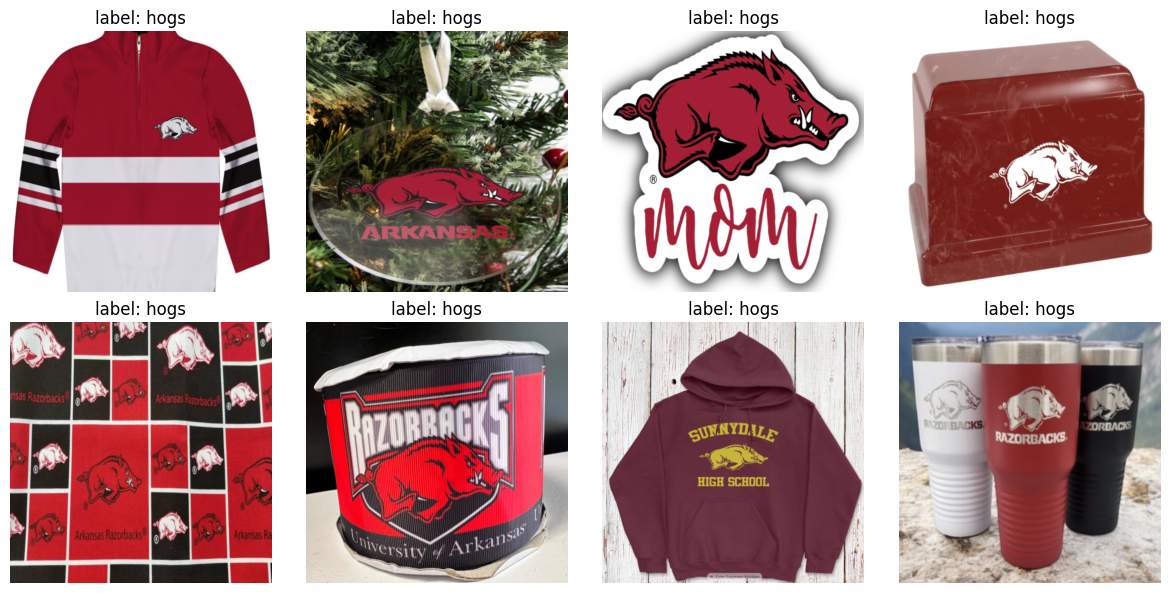

Shown a sample of images from the dataset.


In [20]:
# box 7: Visualize a few sample images

import matplotlib.pyplot as plt

# show a small grid of images from the base_dataset to verify labels & transforms
n_rows, n_cols = 2, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))

for ax, (img, label) in zip(axes.flatten(), base_dataset):
    # img is a tensor in [0,1] with shape [C,H,W]
    img_np = img.permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    ax.set_title(f"label: {base_dataset.classes[label]}")
    ax.axis("off")

plt.tight_layout()
plt.show()
print("Shown a sample of images from the dataset.")

In [21]:
# box 8: Model
model=nn.Sequential(
    nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
    nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(),
    nn.Linear(128,64), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(64,2)
).to(device)


In [22]:
# box 9: Loss & optim
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [23]:
# box 10: Train & evaluation utilities

def accuracy_from_logits(logits, y):
    """Compute accuracy given model logits and true labels."""
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

def run_epoch(model, dataloader, optimizer=None, loss_fn=loss_fn, device=device):
    """Run one epoch over a dataloader.

    If optimizer is provided, the model is set to train mode and parameters updated.
    If optimizer is None, the model is set to eval mode and no gradients are computed.
    Returns average loss and accuracy for the epoch.
    """
    if optimizer is None:
        model.eval()
        torch.set_grad_enabled(False)
    else:
        model.train()
        torch.set_grad_enabled(True)

    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    for xb, yb in dataloader:
        xb = xb.to(device)
        yb = yb.to(device)

        if optimizer is not None:
            optimizer.zero_grad()

        logits = model(xb)
        loss = loss_fn(logits, yb)

        if optimizer is not None:
            loss.backward()
            optimizer.step()

        batch_size = xb.size(0)
        total_loss += loss.item() * batch_size

        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total_examples += batch_size

    avg_loss = total_loss / max(total_examples, 1)
    avg_acc = total_correct / max(total_examples, 1)

    # always restore gradient setting to default (on)
    torch.set_grad_enabled(True)
    return avg_loss, avg_acc

def train(model, epochs, train_dl, valid_dl, optimizer=optimizer, loss_fn=loss_fn, device=device):
    """Train the CNN model and track metrics across epochs.

    This closely follows the structure of the in-class MNIST CNN example:
    * for each epoch, run a training pass and a validation pass
    * record loss and accuracy for both splits
    * print a short training log
    """
    history = {
        "train_loss": [],
        "train_acc": [],
        "valid_loss": [],
        "valid_acc": [],
    }

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = run_epoch(model, train_dl, optimizer=optimizer, loss_fn=loss_fn, device=device)
        valid_loss, valid_acc = run_epoch(model, valid_dl, optimizer=None, loss_fn=loss_fn, device=device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["valid_loss"].append(valid_loss)
        history["valid_acc"].append(valid_acc)

        print(f"Epoch {epoch:02d}/{epochs:02d} | "
              f"train loss: {train_loss:.4f} acc: {train_acc:.4f} | "
              f"valid loss: {valid_loss:.4f} acc: {valid_acc:.4f}")

    return history

Epoch 01/15 | train loss: 0.6919 acc: 0.5250 | valid loss: 0.6926 acc: 0.5000
Epoch 02/15 | train loss: 0.6964 acc: 0.4500 | valid loss: 0.6894 acc: 0.6000
Epoch 03/15 | train loss: 0.6769 acc: 0.6750 | valid loss: 0.6786 acc: 0.7000
Epoch 04/15 | train loss: 0.6620 acc: 0.7000 | valid loss: 0.6776 acc: 0.6000
Epoch 05/15 | train loss: 0.6533 acc: 0.6500 | valid loss: 0.6158 acc: 0.9000
Epoch 06/15 | train loss: 0.6542 acc: 0.6250 | valid loss: 0.5916 acc: 0.9000
Epoch 07/15 | train loss: 0.6390 acc: 0.6750 | valid loss: 0.6928 acc: 0.6000
Epoch 08/15 | train loss: 0.6329 acc: 0.7000 | valid loss: 0.5232 acc: 0.9000
Epoch 09/15 | train loss: 0.6047 acc: 0.6250 | valid loss: 0.5112 acc: 0.9000
Epoch 10/15 | train loss: 0.5722 acc: 0.7500 | valid loss: 0.5770 acc: 0.6000
Epoch 11/15 | train loss: 0.5026 acc: 0.7250 | valid loss: 0.4874 acc: 0.9000
Epoch 12/15 | train loss: 0.4394 acc: 0.8500 | valid loss: 0.3609 acc: 0.9000
Epoch 13/15 | train loss: 0.4541 acc: 0.7750 | valid loss: 0.310

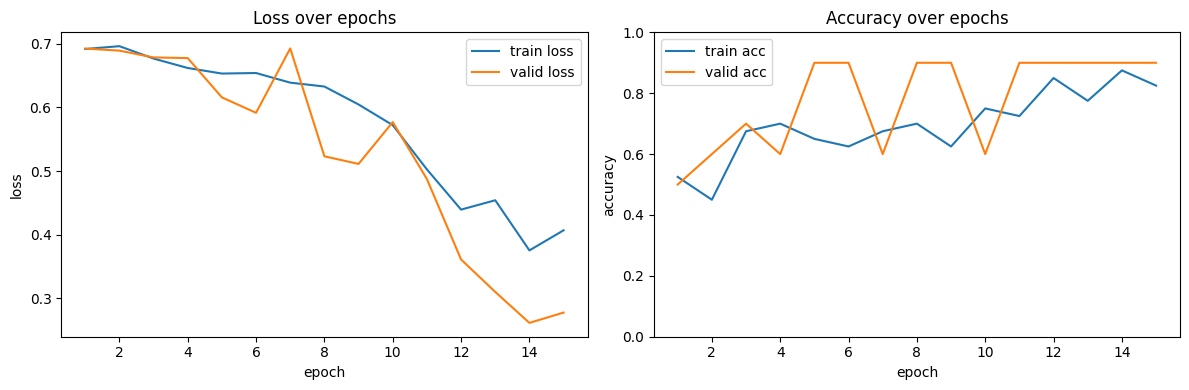

Final validation loss: 0.2775, accuracy: 0.9000
Saved full model to: /content/drive/MyDrive/Group_3_CNN_FullModel.ph


In [24]:
# box 11–14: Train model, plot metrics, and save full model

# 1) Train the model
history = train(model, NUM_EPOCHS, train_dl, valid_dl)

# 2) Plot training & validation loss / accuracy
epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_loss"], label="train loss")
plt.plot(epochs_range, history["valid_loss"], label="valid loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Loss over epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_acc"], label="train acc")
plt.plot(epochs_range, history["valid_acc"], label="valid acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.ylim(0.0, 1.0)
plt.title("Accuracy over epochs")

plt.tight_layout()
plt.show()

# 3) Simple evaluation on validation set (final metrics)
final_valid_loss, final_valid_acc = run_epoch(model, valid_dl, optimizer=None, loss_fn=loss_fn, device=device)
print(f"Final validation loss: {final_valid_loss:.4f}, accuracy: {final_valid_acc:.4f}")

# 4) Save full model for later use (meets project deliverable)
save_dir = Path("/content/drive/MyDrive")
save_dir.mkdir(parents=True, exist_ok=True)
model_filename = f"Group_{GROUP_NUMBER}_CNN_FullModel.ph"
save_path = save_dir / model_filename

torch.save(model, save_path)
print(f"Saved full model to: {save_path}")

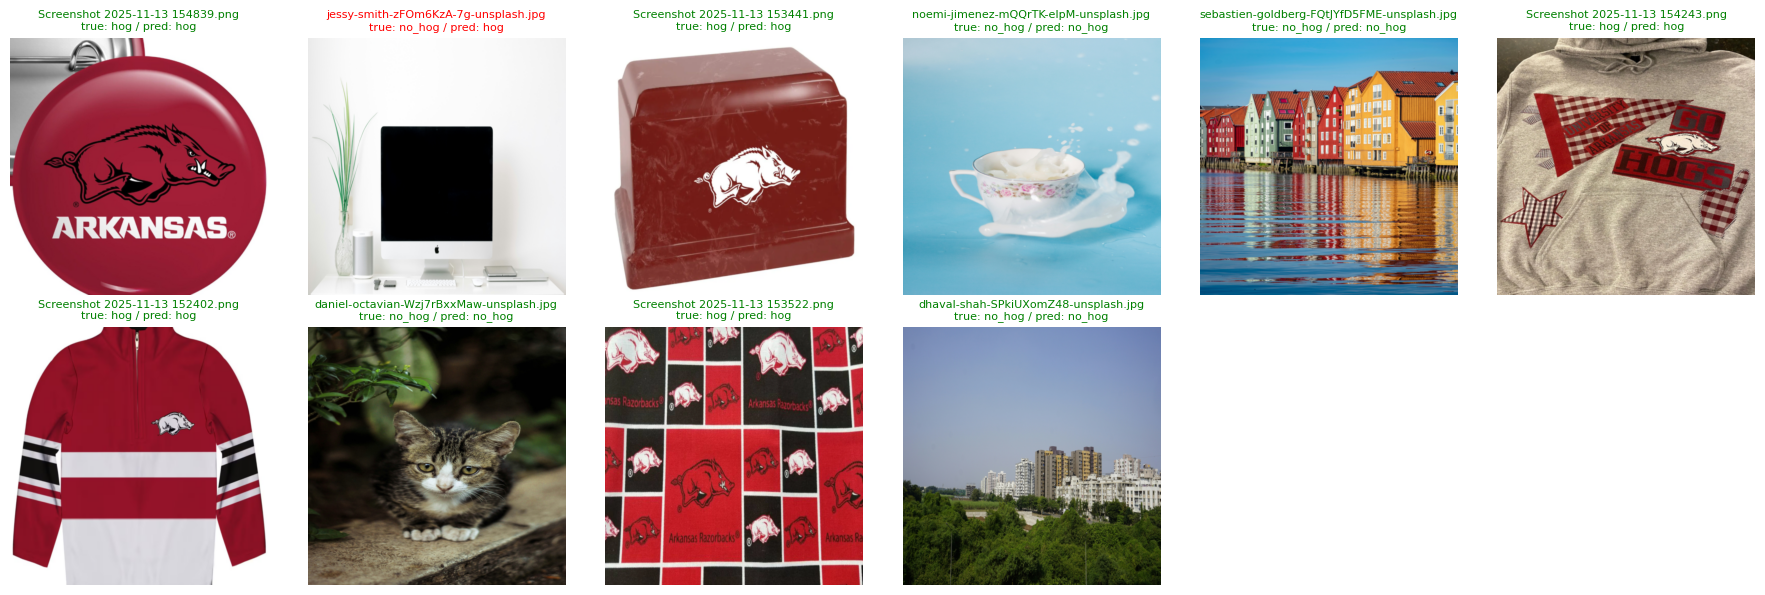

In [25]:
import math
import matplotlib.pyplot as plt

# 0 = no_hogs_random, 1 = hogs (from your wrapper)
class_names = ["no_hog", "hog"]

def show_validation_predictions(model, max_images=40, n_cols=5):
    model.eval()

    images = []
    true_labels = []
    pred_labels = []
    filenames = []

    with torch.no_grad():
        for idx in valid_indices:  # from your split block
            # get transformed image + mapped label (0/1) from full_dataset
            img, y_true = full_dataset[idx]

            # get original path from base_dataset
            path, _ = base_dataset.samples[idx]
            fname = os.path.basename(path)

            # move image to device, add batch dimension
            logits = model(img.unsqueeze(0).to(device))
            y_pred = logits.argmax(dim=1).item()

            images.append(img)
            true_labels.append(y_true)
            pred_labels.append(y_pred)
            filenames.append(fname)

            if len(images) >= max_images:
                break

    num_images = len(images)
    n_rows = math.ceil(num_images / n_cols)

    plt.figure(figsize=(3 * n_cols, 3 * n_rows))

    for i, (img, y_t, y_p, fname) in enumerate(zip(images, true_labels, pred_labels, filenames)):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        # C,H,W -> H,W,C
        ax.imshow(img.permute(1, 2, 0))
        ax.axis("off")

        color = "green" if y_t == y_p else "red"
        ax.set_title(
            f"{fname}\ntrue: {class_names[y_t]} / pred: {class_names[y_p]}",
            color=color,
            fontsize=8
        )

    plt.tight_layout()
    plt.show()

# call it:
show_validation_predictions(model, max_images=len(valid_indices), n_cols=6)


In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def eval_on_valid(model):
    model.eval()
    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for x, y in valid_dl:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            y_true_all.extend(y.cpu().numpy())
            y_pred_all.extend(preds.cpu().numpy())

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)

    cm = confusion_matrix(y_true_all, y_pred_all)
    print("Confusion matrix (rows=true, cols=pred):")
    print(cm)

    print("\nClassification report:")
    print(classification_report(y_true_all, y_pred_all, target_names=class_names))

eval_on_valid(model)


Confusion matrix (rows=true, cols=pred):
[[4 1]
 [0 5]]

Classification report:
              precision    recall  f1-score   support

      no_hog       1.00      0.80      0.89         5
         hog       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10

